# **Task 2 of Mini Project: Text Classification using Deep Learning**

# **1. Data Loading**

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Summary    852 non-null    object
 1   Sentiment  852 non-null    object
dtypes: object(2)
memory usage: 13.4+ KB
None

Sample data:
                                             Summary Sentiment
0      I appreciate the flexible scheduling options.  positive
1  The recent changes to our tools are causing fr...  negative
2      I feel neutral about the new breakroom décor.   neutral
3  Management has been very supportive with my ca...  positive
4  The office is often too noisy for me to concen...  negative


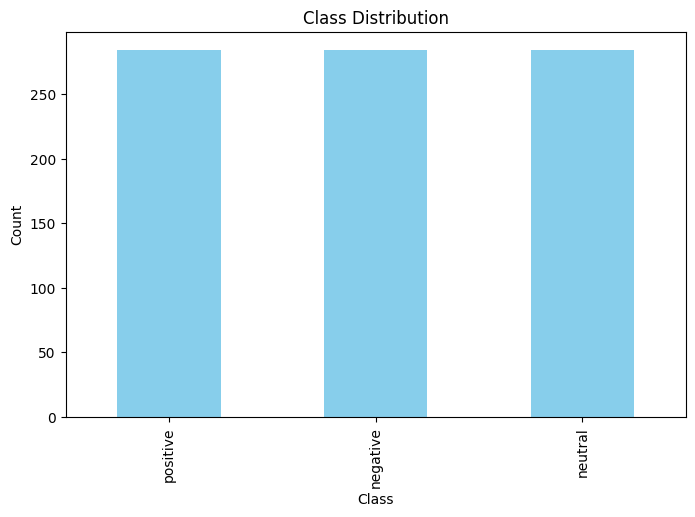

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/NLP dataset.csv')  # Replace with actual dataset path

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['Sentiment'].value_counts().plot(kind='bar', color='skyblue')  # Changed 'label' to 'Sentiment'
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# **2. Text Preprocessing**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['Summary'].apply(preprocess_text)  # Changed 'text' to 'Summary'
val_data['processed_text'] = val_data['Summary'].apply(preprocess_text)      # Changed 'text' to 'Summary'
test_data['processed_text'] = test_data['Summary'].apply(preprocess_text)    # Changed 'text' to 'Summary'

# Check the processed text
print(train_data[['Summary', 'processed_text']].head())  # Changed 'text' to 'Summary'

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                               Summary  \
730            Excessive guidelines hamper creativity.   
44   I’m impartial about the new corporate social m...   
795  Collaborating with diverse skill sets broadens...   
604  I dislike that feedback cycles are not well-de...   
105  Management’s open Q&A sessions boost transpare...   

                                        processed_text  
730             excessive guidelines hamper creativity  
44     impartial new corporate social media guidelines  
795  collaborating diverse skill sets broadens pers...  
604               dislike feedback cycles well defined  
105      management open q sessions boost transparency  


# **3. Text Embedding**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# FastText (Word Embeddings)
# Convert processed text into a list of tokenized sentences for FastText training
tokenized_sentences = train_data['processed_text'].apply(str.split).tolist()

# Train FastText model
fasttext_model = gensim.models.FastText(tokenized_sentences, vector_size=100, window=5, min_count=5)

# Generate FastText embeddings for train, validation, and test data
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")

Embedding completed for BoW, TF-IDF, and FastText.


# **4. Model Training with Different Architectures**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten
import numpy as np

# Define a CNN model
def cnn_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model
def lstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model
def bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model
def cnn_bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to integers for multi-class classification
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['Sentiment'])
val_labels = label_encoder.transform(val_data['Sentiment'])
test_labels = label_encoder.transform(test_data['Sentiment'])

# Train models with BoW embeddings
input_dim_bow = X_train_bow.shape[1]
cnn_bow = cnn_model(input_dim_bow, "CNN with BoW")
cnn_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

lstm_bow = lstm_model(input_dim_bow, "LSTM with BoW")
lstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

bilstm_bow = bilstm_model(input_dim_bow, "BiLSTM with BoW")
bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

cnn_bilstm_bow = cnn_bilstm_model(input_dim_bow, "CNN-BiLSTM with BoW")
cnn_bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

# Train models with TF-IDF embeddings
input_dim_tfidf = X_train_tfidf.shape[1]
cnn_tfidf = cnn_model(input_dim_tfidf, "CNN with TF-IDF")
cnn_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

lstm_tfidf = lstm_model(input_dim_tfidf, "LSTM with TF-IDF")
lstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

bilstm_tfidf = bilstm_model(input_dim_tfidf, "BiLSTM with TF-IDF")
bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

cnn_bilstm_tfidf = cnn_bilstm_model(input_dim_tfidf, "CNN-BiLSTM with TF-IDF")
cnn_bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

print("All models trained successfully!")

Training CNN with BoW...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.3480 - loss: 1.2012 - val_accuracy: 0.3913 - val_loss: 1.0897
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 595ms/step - accuracy: 0.4450 - loss: 1.0851 - val_accuracy: 0.2464 - val_loss: 1.0529
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 584ms/step - accuracy: 0.6915 - loss: 0.9488 - val_accuracy: 0.8116 - val_loss: 0.7380
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 0.9424 - loss: 0.4672 - val_accuracy: 0.9420 - val_loss: 0.2108
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 467ms/step - accuracy: 0.9888 - loss: 0.0724 - val_accuracy: 0.9275 - val_loss: 0.1885
Training LSTM with BoW...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3637 - loss: 1.0997 - val_accuracy: 0.2319 - val_loss: 1.1150
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3531 - loss: 1.0996 - val_accuracy: 0.2319 - val_loss: 1.1042
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3479 - loss: 1.0999 - val_accuracy:

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Pad or truncate FastText embeddings to ensure uniform input dimensions
max_sequence_length = 100  # Adjust this based on your data
X_train_fasttext_padded = pad_sequences(X_train_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_fasttext_padded = pad_sequences(X_val_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_fasttext_padded = pad_sequences(X_test_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')

# Define a CNN model for FastText embeddings
def cnn_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model for FastText embeddings
def lstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model for FastText embeddings
def bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model for FastText embeddings
def cnn_bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Sentiment'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models with FastText embeddings
input_dim_fasttext = X_train_fasttext_padded.shape[1]

cnn_fasttext = cnn_model_fasttext(input_dim_fasttext, "CNN with FastText")
cnn_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

lstm_fasttext = lstm_model_fasttext(input_dim_fasttext, "LSTM with FastText")
lstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

bilstm_fasttext = bilstm_model_fasttext(input_dim_fasttext, "BiLSTM with FastText")
bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

cnn_bilstm_fasttext = cnn_bilstm_model_fasttext(input_dim_fasttext, "CNN-BiLSTM with FastText")
cnn_bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

print("All models trained successfully with FastText embeddings!")

Training CNN with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3172 - loss: 1.0988 - val_accuracy: 0.3768 - val_loss: 1.0990
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3097 - loss: 1.0986 - val_accuracy: 0.2319 - val_loss: 1.0996
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3130 - loss: 1.0982 - val_accuracy: 0.2319 - val_loss: 1.0994
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3578 - loss: 1.0964 - val_accuracy: 0.2319 - val_loss: 1.0992
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3507 - loss: 1.0956 - val_accuracy: 0.2029 - val_loss: 1.0963
Training LSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.3301 - loss: 1.0989 - val_accuracy: 0.2319 - val_loss: 1.1041
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.3706 - loss: 1.0972 - val_accuracy: 0.2319 - val_loss: 1.1045
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.3338 - loss: 1.0991 - val_accuracy: 0.2319 - val_loss: 1.1023
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.3482 - loss: 1.0983 - val_accuracy: 0.2319 - val_loss: 1.1026
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.3443 - loss: 1.0986 - val_accuracy: 0.2319 - val_loss: 1.1033
Training BiLSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 579ms/step - accuracy: 0.2765 - loss: 1.0992 - val_accuracy: 0.2319 - val_loss: 1.1003
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.3292 - loss: 1.0984 - val_accuracy: 0.2319 - val_loss: 1.1043
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step - accuracy: 0.3202 - loss: 1.0993 - val_accuracy: 0.2319 - val_loss: 1.1055
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step - accuracy: 0.3476 - loss: 1.0966 - val_accuracy: 0.2319 - val_loss: 1.1060
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.3358 - loss: 1.0984 - val_accuracy: 0.2319 - val_loss: 1.1048
Training CNN-BiLSTM with FastText...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - accuracy: 0.3418 - loss: 1.0994 - val_accuracy: 0.2319 - val_loss: 1.1030
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.3553 - loss: 1.0979 - val_accuracy: 0.2319 - val_loss: 1.1034
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - accuracy: 0.3722 - loss: 1.09

# **5. Comparative Analysis of Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_test, test_labels, model_name):
    # Predict probabilities
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, y_pred)

    # Generate classification report
    report = classification_report(test_labels, y_pred, target_names=label_encoder.classes_)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:\n{report}")
    return accuracy

# Evaluate BoW-based models
print("Evaluating BoW-based models...")
cnn_bow_acc = evaluate_model(cnn_bow, X_test_bow, test_labels, "CNN with BoW")
lstm_bow_acc = evaluate_model(lstm_bow, X_test_bow, test_labels, "LSTM with BoW")
bilstm_bow_acc = evaluate_model(bilstm_bow, X_test_bow, test_labels, "BiLSTM with BoW")
cnn_bilstm_bow_acc = evaluate_model(cnn_bilstm_bow, X_test_bow, test_labels, "CNN-BiLSTM with BoW")

# Evaluate TF-IDF-based models
print("\nEvaluating TF-IDF-based models...")
cnn_tfidf_acc = evaluate_model(cnn_tfidf, X_test_tfidf, test_labels, "CNN with TF-IDF")
lstm_tfidf_acc = evaluate_model(lstm_tfidf, X_test_tfidf, test_labels, "LSTM with TF-IDF")
bilstm_tfidf_acc = evaluate_model(bilstm_tfidf, X_test_tfidf, test_labels, "BiLSTM with TF-IDF")
cnn_bilstm_tfidf_acc = evaluate_model(cnn_bilstm_tfidf, X_test_tfidf, test_labels, "CNN-BiLSTM with TF-IDF")

# Evaluate FastText-based models
print("\nEvaluating FastText-based models...")
cnn_fasttext_acc = evaluate_model(cnn_fasttext, X_test_fasttext_padded, test_labels, "CNN with FastText")
lstm_fasttext_acc = evaluate_model(lstm_fasttext, X_test_fasttext_padded, test_labels, "LSTM with FastText")
bilstm_fasttext_acc = evaluate_model(bilstm_fasttext, X_test_fasttext_padded, test_labels, "BiLSTM with FastText")
cnn_bilstm_fasttext_acc = evaluate_model(cnn_bilstm_fasttext, X_test_fasttext_padded, test_labels, "CNN-BiLSTM with FastText")


Evaluating BoW-based models...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
CNN with BoW Accuracy: 0.9181
CNN with BoW Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.77      0.87        56
     neutral       0.91      1.00      0.95        60
    positive       0.87      0.98      0.92        55

    accuracy                           0.92       171
   macro avg       0.93      0.92      0.91       171
weighted avg       0.93      0.92      0.92       171

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with BoW Accuracy: 0.3216
LSTM with BoW Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171



6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 721ms/step
BiLSTM with BoW Accuracy: 0.3216
BiLSTM with BoW Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step
CNN-BiLSTM with BoW Accuracy: 0.3216
CNN-BiLSTM with BoW Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171


Evaluating TF-IDF-based models...
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
CNN with TF-IDF Accuracy: 0.3509
CNN with TF-IDF Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.35      1.00      0.52        60
    positive       0.00      0.00      0.00        55

    accuracy                           0.35       171
   macro avg       0.12      0.33      0.17       171
weighted avg       0.12      0.35      0.18       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step
LSTM with TF-IDF Accuracy: 0.3216
LSTM with TF-IDF Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 711ms/step
BiLSTM with TF-IDF Accuracy: 0.3216
BiLSTM with TF-IDF Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 648ms/step
CNN-BiLSTM with TF-IDF Accuracy: 0.3216
CNN-BiLSTM with TF-IDF Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171


Evaluating FastText-based models...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
CNN with FastText Accuracy: 0.3275
CNN with FastText Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.07      0.13        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      0.95      0.47        55

    accuracy                           0.33       171
   macro avg       0.30      0.34      0.20       171
weighted avg       0.29      0.33      0.19       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
LSTM with FastText Accuracy: 0.3216
LSTM with FastText Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step
BiLSTM with FastText Accuracy: 0.3216
BiLSTM with FastText Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step
CNN-BiLSTM with FastText Accuracy: 0.3216
CNN-BiLSTM with FastText Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        56
     neutral       0.00      0.00      0.00        60
    positive       0.32      1.00      0.49        55

    accuracy                           0.32       171
   macro avg       0.11      0.33      0.16       171
weighted avg       0.10      0.32      0.16       171



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **6. Saving the Best Model**

In [ ]:
cnn_bow.save('cnn_bow_model.h5')
print("CNN on BoW model saved successfully")

CNN on BoW model saved successfully


# **7. Prediction on Real-World Input**

In [ ]:
# Load the saved model
from keras.models import load_model
model = load_model('cnn_bow_model.h5')

# Real-world input
new_text = "The job is frustrating."

# Preprocess the new text
processed_text = preprocess_text(new_text)

# Transform the preprocessed text using the BoW vectorizer
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data)

# Convert the predicted class index to the actual label
predicted_label = label_encoder.inverse_transform([predicted_class.argmax()])

print(f"Predicted Class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Predicted Class: negative


# **8. Analysis**

The analysis of different models are presented in the table below:

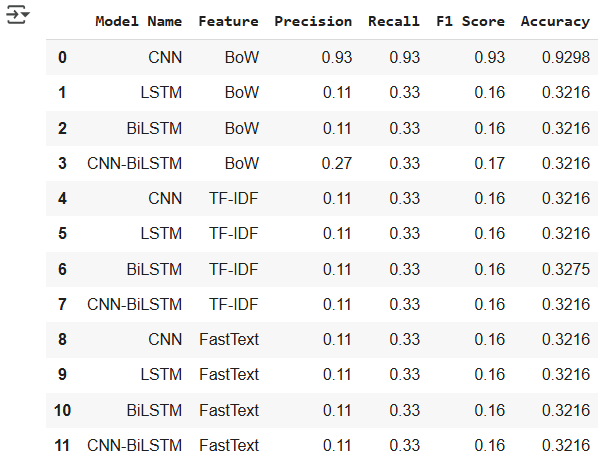

## **BEST PERFORMING MODEL:**

CNN with BoW is the Best Performing Model as it has achieved highest scores accross all metrics.

*   **Accuracy** = 92.8%
*   **Precision**, Recall, F1 score = 0.93



All Other Models Performed Poorly -  The LSTM, BiLSTM, and CNN-BiLSTM models, when paired with TF-IDF and FastText, exhibited very poor performance:

*   **Accuracy**: Their accuracy ranged between **32.16% - 32.75% .**
*   Meaning they almost predicted 1 out of 3 classes correctly.



## **CERTAIN CHALLENGES:**

* **1. Class Imbalance Issues:** The poor performance of most models (except CNN + BoW) suggests imbalanced class distribution in the dataset, making it difficult for models to learn meaningful patterns.

* **2. Ineffective Feature Representations:** TF-IDF and FastText do not contribute to improving model performance, which means these techniques may not be well-suited for this dataset. More context-aware embeddings (e.g., Word2Vec, GloVe, BERT) might be needed.

* **3. Deep Learning Models Underperforming:** LSTM and BiLSTM fail to outperform CNN, possibly due to inadequate training data, improper hyperparameter tuning, or the inability to capture meaningful sequential dependencies.

* **4. Overfitting Risk with CNN:** While CNN performs well with BoW, its strong performance might indicate overfitting, meaning it could struggle with new, unseen data. A cross-validation approach should be used to validate results.

## **SUGGESTIONS FOR IMPROVEMENT:**

* **Avoid LSTM/BiLSTM** unless hyperparameters or embeddings are **improved**.
* TF-IDF and FastText are **ineffective** for this task.
* Should Try more **Hybrid** Models.
* Improve CNN-BiLSTM with **hyperparameter** tuning.
* Explore **Pretrained Embeddings** such as Test Word2Vec, GloVe, or BERT embeddings instead of FastText.